In [181]:
import sys
sys.path.insert(0, '..')

In [182]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [183]:
wid = 64
oversample = 4

nwavels = 20

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)


#ddir = "../data/MAST_2024-09-08T07_59_18.213Z/"
#fname = ddir + 'HST/n43ca5feq_cal.fits'

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


exposures = [

    #exposure_from_file(ddir + 'n8yj03tgq_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),

    #exposure_from_file(ddir + 'n8yj02wyq_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),
    #exposure_from_file(ddir + 'n8yj02x0q_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),

    #exposure_from_file(fname, SinglePointFit(), crop=wid),
    exposure_from_file(ddir + 'n8yj53vfq_cal.fits', SinglePointFourierSpectrumFit(nwavels), crop=wid),
    #exposure_from_file(ddir + 'n8yj53vfq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(ddir + 'n8yj03tiq_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),

]

Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj53vfq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None


In [184]:
#exposures[2].target

In [185]:
exposures[0].filter

'F110W'

In [186]:
y,x = numpy.unravel_index(numpy.nanargmax(exposures[0].data),exposures[0].data.shape)
print(x,y)

31 31


In [187]:
exposures[0].filter

'F110W'

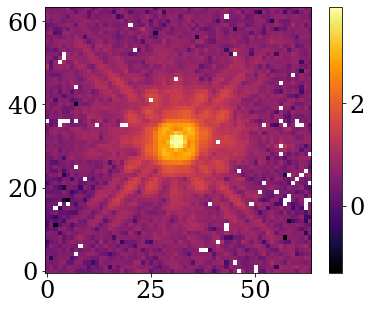

In [188]:
plt.imshow(np.log10(exposures[0].data/exposures[0].err))
plt.colorbar()

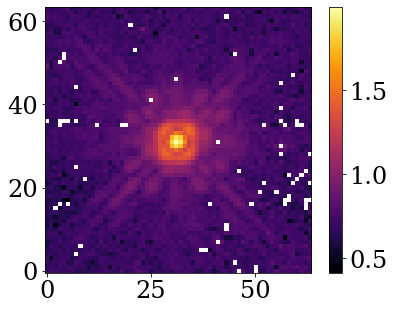

In [189]:
plt.imshow(exposures[0].data**0.125)
plt.colorbar()

In [190]:
params = {
    #"#fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([-0.5,-0.5])
    #params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.log10(np.nansum(exp.data))

    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(7)*(np.nansum(exp.data)/nwavels)#.at[0].set(1)

    #params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.asarray([1/2+1/2, -1/np.pi, 0, -1/(2*np.pi), 0, -1/(3*np.pi), 0, -1/(4*np.pi), 0, -1/(5*np.pi), 0, -1/(6*np.pi), 0, -1/(7*np.pi), 0])[:9]#*(np.nansum(exp.data)/nwavels)

    #params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(npoly)#.at[0].set(1)


    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [191]:
params

ModelParams(
  params={
    'positions':
    {'n8yj53vfq': f32[2]},
    'spectrum':
    {'U10764_F110W': f32[7]},
    'aberrations':
    {'n8yj53vfq': f32[26]},
    'cold_mask_shift':
    {'n8yj53vfq': f32[2]},
    'cold_mask_rot':
    {'F110W': -45.0},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_shear':
    {'F110W': f32[2]},
    'outer_radius':
    1.146,
    'secondary_radius':
    0.44639999999999996,
    'spider_width':
    0.0924,
    'scale':
    0.0432,
    'rot':
    0.0,
    'softening':
    2.0
  }
)

In [192]:
print(params.params)

{'positions': {'n8yj53vfq': Array([-0.5, -0.5], dtype=float32)}, 'spectrum': {'U10764_F110W': Array([144.80775, 144.80775, 144.80775, 144.80775, 144.80775, 144.80775,
       144.80775], dtype=float32)}, 'aberrations': {'n8yj53vfq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'cold_mask_shift': {'n8yj53vfq': Array([6., 6.], dtype=float32)}, 'cold_mask_rot': {'F110W': -45.0}, 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)}, 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)}, 'primary_scale': {'F110W': Array([1., 1.], dtype=float32)}, 'primary_rot': {'F110W': -45.0}, 'primary_shear': {'F110W': Array([0., 0.], dtype=float32)}, 'outer_radius': 1.146, 'secondary_radius': 0.44639999999999996, 'spider_width': 0.0924, 'scale': 0.0432, 'rot': 0.0, 'softening': 2.0}


In [193]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*15, 0),
    "spectrum": opt(g*10, 20),# (20, g*30)),
    #"cold_mask_shift": opt(g*100, 70),
    #"cold_mask_rot": opt(g*100, 120),
    #"cold_mask_scale": opt(g*3000, 150),
    #"cold_mask_shear": opt(g*1000, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    "aberrations": opt(g*10,50),#, (150, g*0.2)),
    #"spectrum": opt(g*50, 20)#, (150, g*200), (200, g*300), (250, g*400)),
    #"spectrum": opt(g*0.01, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [194]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [195]:
rc = True
fishers = calc_fishers(model, exposures, paths, recalculate=rc)
lrs = calc_lrs(model, exposures, fishers, paths)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [196]:
fishers

{'n8yj53vfq': {'positions': Array([[4567320.5, -554417.7],
         [-554417.6, 4476919.5]], dtype=float32),
  'spectrum': Array([[-364.27155 ,  -33.081036,  199.59764 , -129.18767 ,   19.797369,
           290.99524 ,   46.12512 ],
         [ -33.08096 , -206.00504 ,  -67.39949 ,   83.07184 ,  161.85179 ,
            84.43227 ,  -24.862143],
         [ 199.59772 ,  -67.39949 , -182.69023 ,  122.589455,  124.99363 ,
          -159.09358 ,  -61.41792 ],
         [-129.18762 ,   83.0718  ,  122.58942 , -124.03884 ,  -92.108734,
           119.49178 ,   31.635239],
         [  19.797333,  161.8519  ,  124.99365 ,  -92.10874 , -267.52252 ,
            -8.67655 ,   87.14018 ],
         [ 290.99533 ,   84.43224 , -159.09358 ,  119.49185 ,   -8.676482,
          -321.8525  ,  -11.957521],
         [  46.125114,  -24.862179,  -61.41796 ,   31.635279,   87.14023 ,
           -11.957563,  -68.73102 ]], dtype=float32),
  'aberrations': Array([[ 7.39690125e+02,  2.33788109e+01,  2.84938335e+00,
  

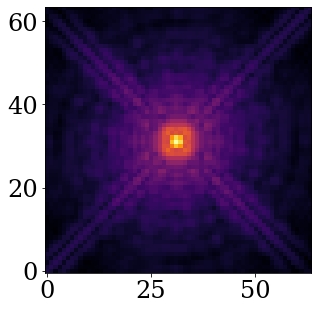

In [197]:
plt.imshow(exposures[0].fit(model,exposures[0])**0.125)

In [198]:
optim, opt_state = zdx.get_optimiser(
    params, groups, optimisers
)


losses, models = [], []
for i in tqdm(range(40)):
    loss, grads = loss_fn(params,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
    updates, opt_state = optim.update(grads, opt_state)
    params = zdx.apply_updates(params, updates)
    
    #if i == 200:
    #    params.set("softening", 0.2)

    #if i == 150:
    #    rc = True
    #    fishers = calc_fishers(model, exposures, paths, recalculate=rc)
    #    lrs = calc_lrs(model, exposures, fishers, paths)

    #params = params.set("spectrum.U10764_F110W", np.abs(params.get("spectrum.U10764_F110W")))

    models.append(params)
    losses.append(loss)


  0%|          | 0/40 [00:00<?, ?it/s]

In [199]:
#model


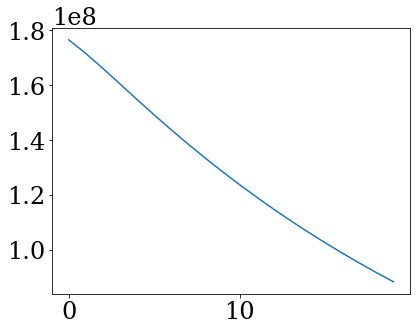

In [200]:
plt.plot(losses[-20:])

3


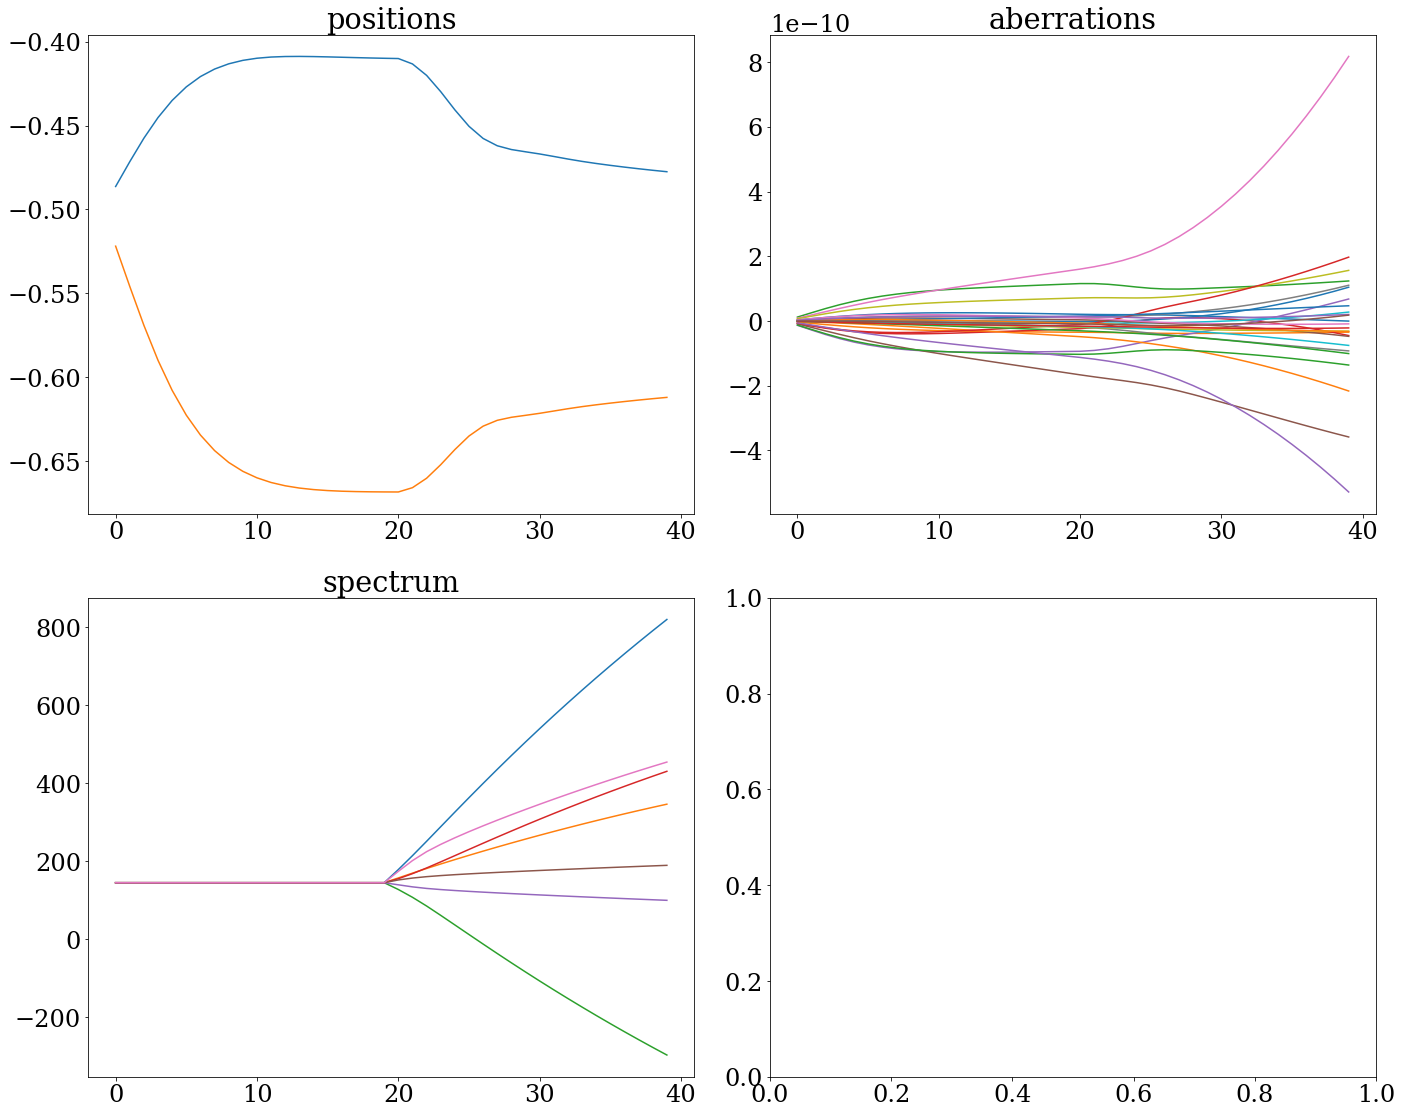

In [201]:
xw = 2
yw = int(np.ceil(len(groups)/xw))

print(len(groups))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", 
                 "cold_mask_shift", "cold_mask_rot", "cold_mask_scale", "cold_mask_shear",
                 "primary_rot","primary_scale", "primary_shear", "breathing", "slope", "spectrum"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        #print(injected_params[param])
        """for j in injected_params[param].values():
            print(j)
            print(len(j.shape))
            if len(j.shape)>0:
                for k in j:
                    sp.axhline(k, color='k', linestyle='--')
            else:
                sp.axhline(j, color='k', linestyle='--')"""
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
        #sp.axhline(injected_params[param], color='k', linestyle='--')

    
fig.tight_layout()

In [202]:
#for exp in exposures:
#    params = params.set("aberrations."+exp.fit.get_key(exp, "aberrations"), -params.get("aberrations."+exp.fit.get_key(exp, "aberrations")))

1.766534e+08, 8.836948e+07


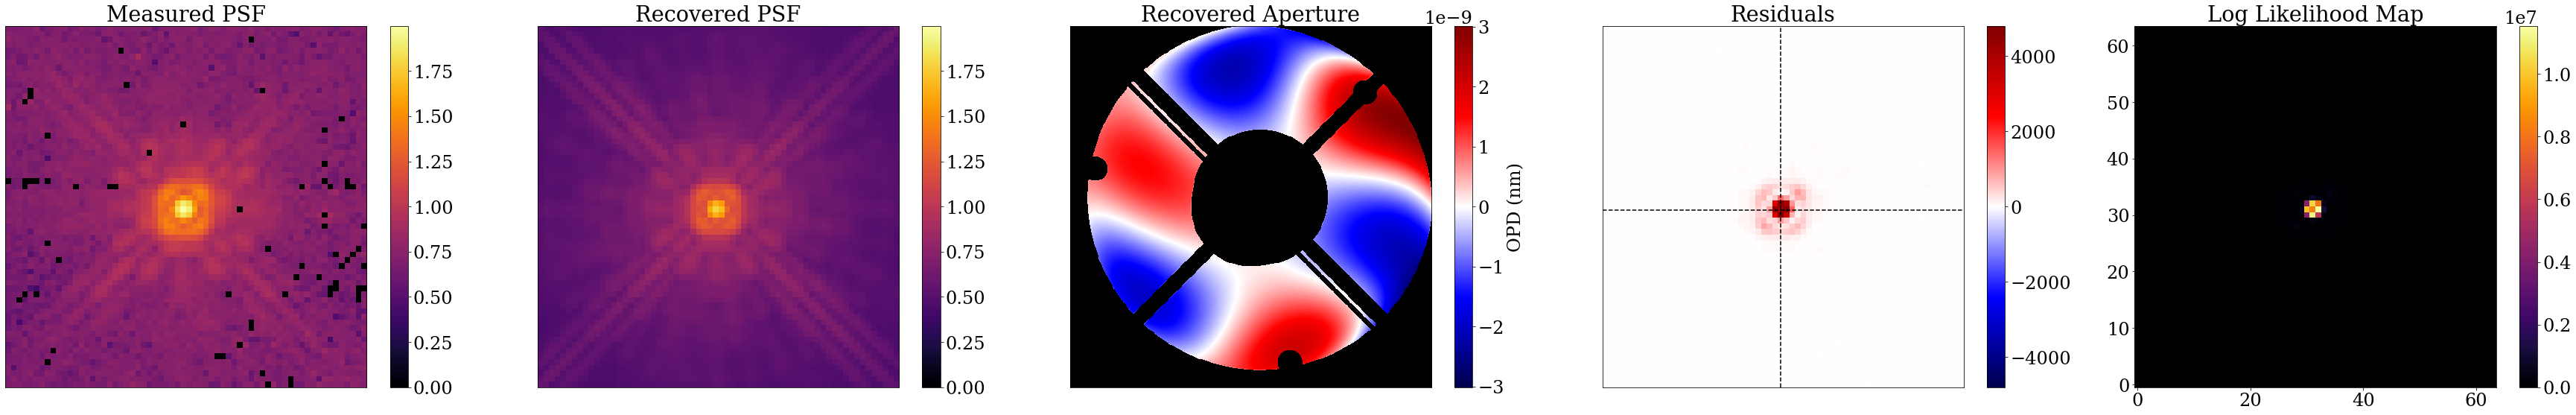

In [203]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

fig, axs = plt.subplots(1,5, figsize=(50,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

exp = exposures[0]


model = params.inject(model)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exp.data**0.125
telescope_frame = exp.fit(model,exp)**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

#start_aberrations = model.get(exp.fit.map_param(exp, "start_aberrations"))#*1e-9
#end_aberrations = model.get(exp.fit.map_param(exp, "end_aberrations"))#*1e-9

#aberrations_model = model.set(exp.map_param("aberrations"), (start_aberrations+end_aberrations)/2)

optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.nanmax(np.abs(opd*support_mask))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exp.data - exp.fit(model,exp))/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

axs[3].axvline((wid-1)/2 + params.get(exp.map_param("positions"))[0], color='k',linestyle='--')
axs[3].axhline((wid-1)/2 + params.get(exp.map_param("positions"))[1], color='k',linestyle='--')


lpdf = posterior(model,exp,return_im=True)#*nanmap
lpd = axs[4].imshow(lpdf)
plt.colorbar(lpd, ax=axs[4])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")
axs[4].set_title("Log Likelihood Map")

for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


In [204]:
params.get("spectrum.U10764_F110W")

Array([ 820.1418 ,  346.24432, -297.25815,  430.5777 ,   99.59691,
        189.34106,  454.2827 ], dtype=float32)

In [205]:
rc = True
fishers = calc_fishers(model, exposures, paths, recalculate=rc)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [206]:
fishers['n8yj53vfq'].keys()

dict_keys(['positions', 'spectrum', 'aberrations'])

In [207]:
fishers['n8yj53vfq']['spectrum']

Array([[ 25.115719  ,  21.5863    , -17.08127   ,  13.072103  ,
         11.396214  ,  -9.073383  ,  12.702861  ],
       [ 21.586298  , -12.41703   ,   1.5486308 ,  -5.9531093 ,
        -12.981622  ,  10.933129  ,  -9.3727665 ],
       [-17.08123   ,   1.548629  ,   3.4635386 ,  -0.06211383,
          3.5444586 ,  -3.0969796 ,   1.4158494 ],
       [ 13.072128  ,  -5.9531274 ,  -0.06213846,  -2.5622597 ,
         -6.3925242 ,   5.405623  ,  -4.346707  ],
       [ 11.396201  , -12.981588  ,   3.5444524 ,  -6.3925314 ,
        -11.62873   ,   9.710202  ,  -9.111167  ],
       [ -9.073352  ,  10.933102  ,  -3.0969687 ,   5.405638  ,
          9.71022   ,  -8.120799  ,   7.6391745 ],
       [ 12.702841  ,  -9.372796  ,   1.4158603 ,  -4.3466725 ,
         -9.111133  ,   7.6391563 ,  -6.7394485 ]], dtype=float32)

In [208]:
np.diag(np.linalg.inv(fishers['n8yj53vfq']['spectrum']/1e5))

Array([   23328.133,   223632.98 ,   320514.66 ,  1393507.4  ,
        8260117.   , -2792878.   ,  6280645.5  ], dtype=float32)

In [209]:
spectrum_cov = np.linalg.inv(fishers['n8yj53vfq']['spectrum'])
spectrum_err = np.diag(np.sqrt(np.abs(spectrum_cov)))

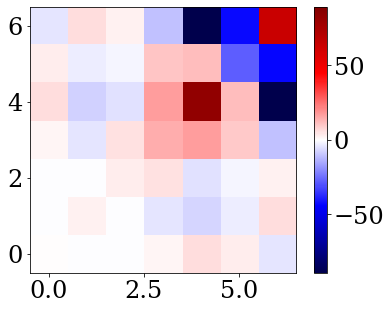

In [210]:
plt.imshow(spectrum_cov, cmap='seismic', vmin=-np.max(np.abs(spectrum_cov)), vmax=np.max(np.abs(spectrum_cov)))
plt.colorbar()


In [211]:
params.params['spectrum']

{'U10764_F110W': Array([ 820.1418 ,  346.24432, -297.25815,  430.5777 ,   99.59691,
         189.34106,  454.2827 ], dtype=float32)}

In [212]:
params.get("spectrum.U10764_F110W")/spectrum_err

Array([1698.1088  ,  231.53532 , -166.03917 ,  115.3455  ,   10.95852 ,
         35.827755,   57.323574], dtype=float32)

In [213]:
params.params

{'aberrations': {'n8yj53vfq': Array([-2.53136813e-13, -3.44028452e-11,  1.23733759e-10, -4.49385702e-11,
          6.79906964e-11, -3.58495233e-10,  8.17849954e-10,  1.10490873e-10,
          1.56451338e-10,  2.75783025e-11,  1.04421194e-10, -2.16363191e-10,
         -1.36140710e-10,  1.97367053e-10, -5.28519228e-10, -4.74331616e-11,
         -8.88414949e-12, -9.24325338e-11, -3.13329952e-11, -7.54809132e-11,
          4.70568549e-11, -3.25419205e-11, -1.00672935e-10, -2.13808641e-11,
          2.01849856e-11,  1.81340221e-11], dtype=float32)},
 'cold_mask_rot': {'F110W': -45.0},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'cold_mask_shift': {'n8yj53vfq': Array([6., 6.], dtype=float32)},
 'outer_radius': 1.146,
 'positions': {'n8yj53vfq': Array([-0.4775211 , -0.61207294], dtype=float32)},
 'primary_rot': {'F110W': -45.0},
 'primary_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'primary_shear': {'F1

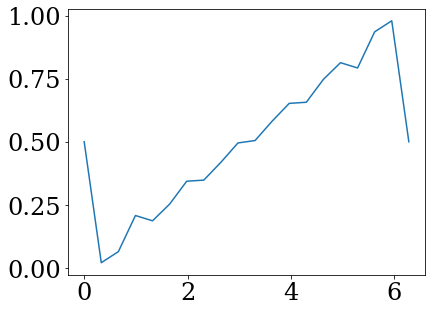

In [214]:
inten = np.zeros(nwavels)
xs = np.linspace(0, 2, nwavels)*np.pi

coeffs = np.asarray([1/2, -1/np.pi, 0, -1/(2*np.pi), 0, -1/(3*np.pi), 0, -1/(4*np.pi), 0, -1/(5*np.pi), 0, -1/(6*np.pi), 0])#params.get("spectrum.U10764_F110W")

#inten += np.ones(nw)*coeffs[0]
#inten += 

for i,c in enumerate(coeffs):
    #inten = inten +  jax.lax.select(i == 0, np.ones(nw), np.zeros(nw))*c
    inten = inten +  jax.lax.select((i % 2) == 0, np.cos(xs*i/2), np.zeros(nwavels))*c
    inten = inten +  jax.lax.select((i % 2) == 1, np.sin(xs*(i+1)/2), np.zeros(nwavels))*c

plt.plot(xs, inten)

In [215]:
from jax.numpy import linalg as la
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False


In [216]:
import numpy

symmetric_cov = spectrum_cov + spectrum_cov.T - np.diag(spectrum_cov.diagonal())

coeffs = numpy.random.multivariate_normal(params.get("spectrum.U10764_F110W"), nearestPD(symmetric_cov))

/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_405/3496161604.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  coeffs = numpy.random.multivariate_normal(params.get("spectrum.U10764_F110W"), nearestPD(symmetric_cov))


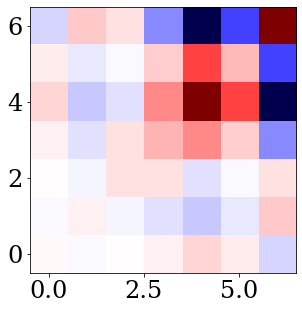

In [217]:
pdc = nearestPD(symmetric_cov)
plt.imshow(pdc, cmap='seismic', vmin=-np.max(np.abs(pdc)), vmax=np.max(np.abs(pdc)))


/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_405/1128704662.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  coeffs = numpy.random.multivariate_normal(params.get("spectrum.U10764_F110W"), nearestPD(symmetric_cov))


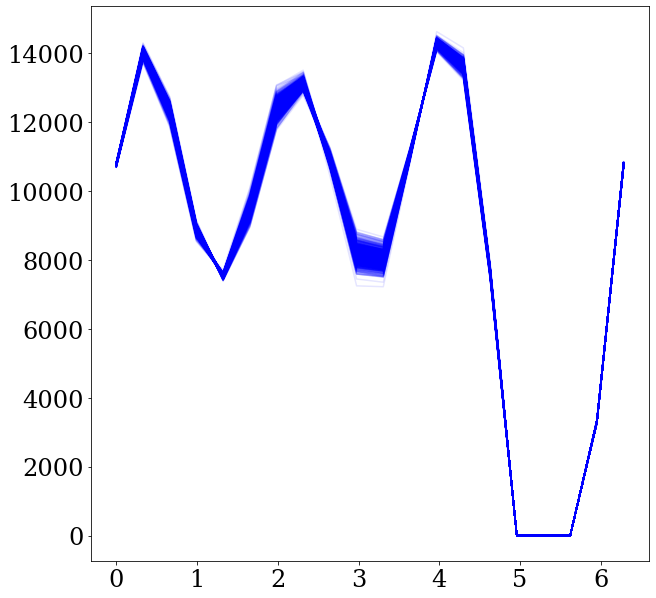

In [218]:
plt.figure(figsize=(10,10))

for i in range(1000):
    coeffs = numpy.random.multivariate_normal(params.get("spectrum.U10764_F110W"), nearestPD(symmetric_cov))

    inten = np.zeros(nwavels)
    xs = np.linspace(0, 2, nwavels)*np.pi

    for i,c in enumerate(coeffs):
    #inten = inten +  jax.lax.select(i == 0, np.ones(nw), np.zeros(nw))*c
        inten = inten +  jax.lax.select((i % 2) == 0, np.cos(xs*i/2), np.zeros(nwavels))*c
        inten = inten +  jax.lax.select((i % 2) == 1, np.sin(xs*(i+1)/2), np.zeros(nwavels))*c



    plt.plot(xs, jax.nn.softplus(inten*10), color='b', alpha=0.1, zorder=0)

#plt.scatter(wavels, params.get("spectrum.U10764_F110W"), color="orange", zorder=1)
